In [ ]:
# Importing libraries
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import keras
import os



import csv,sys
from collections import namedtuple
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import extract_patches
from skimage.util.shape import view_as_windows
import csv
from collections import namedtuple
import random

import segmentation_models as sm
from segmentation_models.utils import set_trainable

import gc
gc.collect()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


27

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Casia Dataset #

In [ ]:
# Casia dataset: https://www.kaggle.com/sophatvathana/casia-dataset : Trained with CASIA 2
'''
REFERENCES
Dong, J.,Wang,W.: CASIA tampered image detection evaluation (TIDE) database, v1.0 and v2.0 (2011). 
http://forensics.idealtest.org/
Warif, N. B. A., Wahab, A. W. A., Idris, M. Y. I., Salleh, R., & Othman, F. (2017). 
SIFT-Symmetry: A Robust Detection Method for Copy-Move Forgery with Reflection Attack. 
http://doi.org/10.1016/j.jvcir.2017.04.004
'''

base_folder='D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test'
#base_folder='G:/sourav/prog/notebook/Image_manipulation_detection-master/data/casia-dataset/casia_test'
data = 'casia_img'

original_images = [os.path.join(base_folder, 'probe')+'/'+x for x in os.listdir(
    os.path.join(base_folder, 'probe')) if x.endswith(".png")]
print(len(original_images))

4647


In [ ]:
train_rows = []
val_rows = []
test_rows = []

for v in original_images:
    rr = random.random()
    if rr<= 0.65:
        train_rows.append(v)
    elif rr <=0.75:
        val_rows.append(v)
    else:
        test_rows.append(v)
        
print(len(train_rows))
print(len(val_rows))
print(len(test_rows))

3018
465
1164


In [ ]:
dic = {
    'train':train_rows,
    'val':val_rows,
    'test':test_rows
}

In [ ]:
for str_type in ['train','val','test']:

    count = 0
    lst = []
    
    # mkdirs
    os.makedirs(os.path.join(base_folder,data,'images',str_type))
    os.makedirs(os.path.join(base_folder,data,'masks',str_type))
    
    print("str_type ",str_type)
    
    for img_path in dic[str_type]: # each image in dic

        IMG_PATH = img_path
        MASK_PATH = img_path.replace('probe', 'mask')
        
        print("IMG_PATH: ",IMG_PATH)
        print("MASK_PATH: ",MASK_PATH)
        
        dim=(256,256)

        probe = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
        prob = cv2.resize(probe, dim, interpolation = cv2.INTER_AREA)
        
        origmask = cv2.imread(MASK_PATH, cv2.IMREAD_UNCHANGED) # here the mask is in rgb form, we need to change to 255
        mask = cv2.resize(origmask, dim, interpolation = cv2.INTER_AREA)
        blur = cv2.GaussianBlur(mask,(5,5),0)
        ret,msk = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        
        assert prob.shape[:2] == msk.shape[:2]
        width,height = prob.shape[:2]

        msk = np.array(msk)
        prob = np.array(prob)
               
        im = Image.fromarray(prob)
        mk = Image.fromarray(msk).convert('RGB')
        
        PROCESSED_IMG_PATH = os.path.join(data, 'images', str_type, str(count)+'.png')
        PROCESSED_MASK_PATH = os.path.join(data, 'masks', str_type, str(count)+'.png')
        
        im.save(base_folder+'/'+PROCESSED_IMG_PATH)
        mk.save(base_folder+'/'+PROCESSED_MASK_PATH)
        
        lst.append(",".join([PROCESSED_IMG_PATH, PROCESSED_MASK_PATH, MASK_PATH.replace(
                    base_folder, ''), IMG_PATH.replace(base_folder, '')]))
        
        count = count + 1
        print('['+str(count)+']') 
        
    with open(os.path.join(base_folder,data,str_type+'.txt'),'w') as f:
        f.write("\n".join(lst)) 


str_type  train
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CND_M_N_art00076_art00077_10289.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CND_M_N_art00076_art00077_10289.png
[1]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CND_S_N_ani00073_ani00068_00193.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CND_S_N_ani00073_ani00068_00193.png
[2]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CND_S_N_ind00078_ind00077_00476.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CND_S_N_ind00078_ind00077_00476.png
[3]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CND_S_N_txt00028_txt00006_10848.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[37]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CNN_S_N_txt00052_txt00051_10377.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CNN_S_N_txt00052_txt00051_10377.png
[38]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CNN_S_O_nat10153_ani00097_12135.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CNN_S_O_nat10153_ani00097_12135.png
[39]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRD_M_B_nat00032_nat00033_10077.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRD_M_B_nat00032_nat00033_10077.png
[40]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRD_M_B_sec00001_sec00003_10031.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[70]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_ani10116_ani00100_11643.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_ani10116_ani00100_11643.png
[71]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_ani10117_ani00100_11642.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_ani10117_ani00100_11642.png
[72]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_ani10118_ani00100_11638.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_ani10118_ani00100_11638.png
[73]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_ani10118_sec00098_11619.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[109]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_nat00086_nat00085_10068.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_nat00086_nat00085_10068.png
[110]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_nat10116_cha00026_11674.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_nat10116_cha00026_11674.png
[111]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_nat10129_cha00086_11522.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_nat10129_cha00086_11522.png
[112]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_nat10131_nat00059_11908.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[146]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_ani10120_ani00100_11618.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_ani10120_ani00100_11618.png
[147]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_ani10120_sec00098_11614.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_ani10120_sec00098_11614.png
[148]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_ani10121_sec00098_11615.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_ani10121_sec00098_11615.png
[149]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_ani10151_ani10206_12489.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[184]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10129_ani00100_11644.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10129_ani00100_11644.png
[185]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10145_ani00022_11986.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10145_ani00022_11986.png
[186]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10145_ani00037_11983.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10145_ani00037_11983.png
[187]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10145_ani00099_11990.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[216]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NND_L_B_arc00033_nat00095_00253.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NND_L_B_arc00033_nat00095_00253.png
[217]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NND_M_B_sec00077_txt00059_10387.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NND_M_B_sec00077_txt00059_10387.png
[218]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NND_M_B_sec00098_nat00033_00118.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NND_M_B_sec00098_nat00033_00118.png
[219]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NND_M_B_sec20062_arc20001_02136.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[256]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_B_sec00015_sec00082_00036.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_B_sec00015_sec00082_00036.png
[257]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_B_sec00036_nat00035_20123.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_B_sec00036_nat00035_20123.png
[258]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_B_sec20045_arc20001_02127.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_B_sec20045_arc20001_02127.png
[259]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_ani00019_nat00095_11863.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[294]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_nat00073_nat00097_11103.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_nat00073_nat00097_11103.png
[295]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_nat00086_arc00076_11283.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_nat00086_arc00076_11283.png
[296]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_nat00095_nat00062_11358.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_nat00095_nat00062_11358.png
[297]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_nat10103_pla10110_10115.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[327]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_txt00066_txt00065_10122.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_txt00066_txt00065_10122.png
[328]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_txt10109_txt00097_10815.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_txt10109_txt00097_10815.png
[329]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_O_ani00036_nat00083_10054.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_O_ani00036_nat00083_10054.png
[330]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_O_arc00041_nat00097_00261.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[363]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_ani00016_ani00013_00136.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_ani00016_ani00013_00136.png
[364]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_ani00017_ani00010_10216.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_ani00017_ani00010_10216.png
[365]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_ani10113_ani10112_11625.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_ani10113_ani10112_11625.png
[366]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_ani10113_ani10114_11631.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[398]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_art00045_cha00096_00519.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_art00045_cha00096_00519.png
[399]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_art00057_ind00018_01403.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_art00057_ind00018_01403.png
[400]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_art00058_ani00031_01402.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_art00058_ani00031_01402.png
[401]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_art10111_ani00100_11620.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[434]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat20022_nat20015_01526.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat20022_nat20015_01526.png
[435]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat20023_nat20015_01527.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat20023_nat20015_01527.png
[436]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat20024_nat20015_01528.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat20024_nat20015_01528.png
[437]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat20055_nat20054_01559.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[470]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_L_B_arc00028_ani00001_00248.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_L_B_arc00028_ani00001_00248.png
[471]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_L_B_arc20049_arc20049_02480.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_L_B_arc20049_arc20049_02480.png
[472]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_L_B_arc20050_arc20001_02477.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_L_B_arc20050_arc20001_02477.png
[473]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_L_B_arc20051_arc20001_02479.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[508]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha00091_ani00058_00411.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_cha00091_ani00058_00411.png
[509]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha00097_ani00077_00417.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_cha00097_ani00077_00417.png
[510]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_ind00050_ind00017_00457.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_ind00050_ind00017_00457.png
[511]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_ind00068_ind00084_10944.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[545]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_B_nat10128_nat00062_11540.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_B_nat10128_nat00062_11540.png
[546]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_B_nat10136_arc00054_11919.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_B_nat10136_arc00054_11919.png
[547]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_B_nat10139_nat10124_11945.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_B_nat10139_nat10124_11945.png
[548]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_B_pla00030_cha00029_20108.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[584]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00013_art00014_10271.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00013_art00014_10271.png
[585]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00014_art00010_11833.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00014_art00010_11833.png
[586]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00014_art00013_10270.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00014_art00013_10270.png
[587]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00025_cha00027_11682.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[616]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_cha00024_nat00099_10323.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_cha00024_nat00099_10323.png
[617]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_cha00024_txt00098_10324.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_cha00024_txt00098_10324.png
[618]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_cha00027_cha00028_11785.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_cha00027_cha00028_11785.png
[619]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_cha00028_cha00026_11788.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[651]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_ind00084_cha00036_11752.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_ind00084_cha00036_11752.png
[652]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_ind00084_cha00063_11753.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_ind00084_cha00063_11753.png
[653]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_ind00100_cha00070_11394.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_ind00100_cha00070_11394.png
[654]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_ind10102_cha00070_11549.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[691]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10116_cha00071_11730.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10116_cha00071_11730.png
[692]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10118_nat10123_11391.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10118_nat10123_11391.png
[693]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10122_nat00097_11337.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10122_nat00097_11337.png
[694]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10123_nat10122_11336.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[724]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10148_nat10142_12125.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10148_nat10142_12125.png
[725]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10148_nat10161_12121.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10148_nat10161_12121.png
[726]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10149_nat00060_12003.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10149_nat00060_12003.png
[727]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10150_nat00013_12031.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[756]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec00014_cha00070_11404.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec00014_cha00070_11404.png
[757]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec00015_cha00062_11399.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec00015_cha00062_11399.png
[758]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec00021_cha00052_11405.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec00021_cha00052_11405.png
[759]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec00062_cha00052_11407.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[790]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_O_sec10101_sec10107_10024.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_O_sec10101_sec10107_10024.png
[791]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_O_sec10105_cha10104_10027.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_O_sec10105_cha10104_10027.png
[792]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_O_sec10107_sec10101_10025.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_O_sec10107_sec10101_10025.png
[793]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_ani00028_ani00029_20111.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[827]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_ind00046_cha00023_00454.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_B_ind00046_cha00023_00454.png
[828]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_ind00055_cha00040_00461.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_B_ind00055_cha00040_00461.png
[829]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_ind00057_ind00018_00463.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_B_ind00057_ind00018_00463.png
[830]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_ind00063_ani00069_00466.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[865]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_B_sec00095_cha00063_00382.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_B_sec00095_cha00063_00382.png
[866]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani00024_ani00021_00144.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani00024_ani00021_00144.png
[867]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani00033_ani00032_10233.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani00033_ani00032_10233.png
[868]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani00033_ani00034_10236.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[899]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10211_ani00100_12375.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10211_ani00100_12375.png
[900]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10213_ani00070_12378.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10213_ani00070_12378.png
[901]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10215_ani00081_12382.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10215_ani00081_12382.png
[902]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10216_ani00070_12389.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[934]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_art00024_ind00098_01424.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_art00024_ind00098_01424.png
[935]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_art00025_ani10123_11689.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_art00025_ani10123_11689.png
[936]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_art00029_art00029_01216.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_art00029_art00029_01216.png
[937]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_art00033_ani00013_00511.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[972]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00032_ani00013_00352.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00032_ani00013_00352.png
[973]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00036_pla00020_11739.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00036_pla00020_11739.png
[974]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00040_ani00013_00360.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00040_ani00013_00360.png
[975]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00041_cha00042_11010.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[1006]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ind00002_art00076_11746.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ind00002_art00076_11746.png
[1007]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ind00002_art00098_11747.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ind00002_art00098_11747.png
[1008]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ind00008_art00009_00426.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ind00008_art00009_00426.png
[1009]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ind00009_pla00050_10423.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1046]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat00059_ani00070_11414.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat00059_ani00070_11414.png
[1047]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat00062_ani00058_11418.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat00062_ani00058_11418.png
[1048]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat00097_ani00017_11412.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat00097_ani00017_11412.png
[1049]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat00098_ani00058_11461.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1077]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10159_ani00070_12052.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10159_ani00070_12052.png
[1078]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10164_ani00058_12091.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10164_ani00058_12091.png
[1079]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat20020_nat20023_01524.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat20020_nat20023_01524.png
[1080]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat20056_nat20054_01560.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1117]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_sec00041_ani00076_10500.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_sec00041_ani00076_10500.png
[1118]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_sec00050_sec00049_00071.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_sec00050_sec00049_00071.png
[1119]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_sec00052_sec00055_11239.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_sec00052_sec00055_11239.png
[1120]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_sec00054_sec00055_11237.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1151]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_M_N_pla00022_pla00022_10969.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_M_N_pla00022_pla00022_10969.png
[1152]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_B_ani00022_ani00022_00142.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_S_B_ani00022_ani00022_00142.png
[1153]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_B_cha00088_cha00088_10179.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_S_B_cha00088_cha00088_10179.png
[1154]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_B_sec00085_sec00085_00105.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1182]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_arc00040_arc00040_10237.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_arc00040_arc00040_10237.png
[1183]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_arc00040_arc00040_10238.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_arc00040_arc00040_10238.png
[1184]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_arc00043_arc00043_10242.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_arc00043_arc00043_10242.png
[1185]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_arc00051_arc00051_10727.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1213]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_cha00017_cha00017_10313.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_cha00017_cha00017_10313.png
[1214]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_cha00063_cha00063_10344.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_cha00063_cha00063_10344.png
[1215]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_cha00073_cha00073_11026.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_cha00073_cha00073_11026.png
[1216]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_cha00078_cha00078_11027.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1253]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_nat00096_nat00096_10600.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_nat00096_nat00096_10600.png
[1254]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_nat10151_nat10151_12110.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_nat10151_nat10151_12110.png
[1255]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_pla00074_pla00074_10620.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_pla00074_pla00074_10620.png
[1256]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_pla00076_pla00076_10622.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1294]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_txt10107_txt10107_10867.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_txt10107_txt10107_10867.png
[1295]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_txt10110_txt10110_10862.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_txt10110_txt10110_10862.png
[1296]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_O_ani00097_ani00097_10101.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_O_ani00097_ani00097_10101.png
[1297]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_O_ani00097_ani00097_10133.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1325]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani00080_ani00080_00820.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_ani00080_ani00080_00820.png
[1326]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani00090_ani00090_00210.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_ani00090_ani00090_00210.png
[1327]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani10160_ani10160_12495.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_ani10160_ani10160_12495.png
[1328]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani10196_ani10196_12404.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1356]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00056_art00056_00524.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00056_art00056_00524.png
[1357]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00058_art00058_01233.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00058_art00058_01233.png
[1358]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00067_art00067_01239.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00067_art00067_01239.png
[1359]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00074_art00074_10537.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1392]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_cha10207_cha10207_12341.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_cha10207_cha10207_12341.png
[1393]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_cha20007_cha20007_02006.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_cha20007_cha20007_02006.png
[1394]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ind00024_ind00024_00439.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_ind00024_ind00024_00439.png
[1395]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ind00025_ind00025_01321.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla00067_pla00067_11217.png
[1430]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_pla00069_pla00069_01176.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla00069_pla00069_01176.png
[1431]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_pla00078_pla00078_10854.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla00078_pla00078_10854.png
[1432]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_pla00081_pla00081_10629.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla00081_pla00081_10629.png
[1433]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-ma

[1470]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_txt00089_txt00089_00686.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_txt00089_txt00089_00686.png
[1471]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_O_pla10128_pla10128_12140.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_O_pla10128_pla10128_12140.png
[1472]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRD_M_B_sec00083_sec00083_11287.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRD_M_B_sec00083_sec00083_11287.png
[1473]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRD_M_N_art00007_art00007_10750.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1505]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRD_S_N_sec00025_sec00025_10776.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRD_S_N_sec00025_sec00025_10776.png
[1506]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRD_S_N_txt00100_txt00100_01293.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRD_S_N_txt00100_txt00100_01293.png
[1507]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_L_N_arc00053_arc00053_10248.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_L_N_arc00053_arc00053_10248.png
[1508]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_B_ani00001_ani00001_10098.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1542]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_nat10137_nat10137_11930.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_nat10137_nat10137_11930.png
[1543]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_nat10161_nat10161_12079.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_nat10161_nat10161_12079.png
[1544]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_nat10164_nat00021_12098.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_nat10164_nat00021_12098.png
[1545]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_pla00037_pla00037_10981.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1577]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_ani10221_ani10221_12391.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_ani10221_ani10221_12391.png
[1578]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_ani10221_ani10221_12393.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_ani10221_ani10221_12393.png
[1579]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_arc00062_ani00005_11499.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_arc00062_ani00005_11499.png
[1580]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_arc00078_art00092_11881.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1612]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha10177_cha10177_12287.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha10177_cha10177_12287.png
[1613]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha10190_cha10190_12326.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha10190_cha10190_12326.png
[1614]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha10199_cha10199_12359.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha10199_cha10199_12359.png
[1615]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha10205_cha10205_12350.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1644]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_pla20037_pla20037_01937.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_pla20037_pla20037_01937.png
[1645]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_pla20055_pla20055_01955.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_pla20055_pla20055_01955.png
[1646]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_pla20058_pla20058_01958.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_pla20058_pla20058_01958.png
[1647]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_pla20064_pla20064_01964.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1681]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_art00004_ani00077_01194.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_art00004_ani00077_01194.png
[1682]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_art00075_art00075_01245.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_art00075_art00075_01245.png
[1683]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_ind00048_ind00048_01338.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_ind00048_ind00048_01338.png
[1684]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_ind00071_ind00071_01358.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1717]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_cha00067_cha00067_00858.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_cha00067_cha00067_00858.png
[1718]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_cha00074_cha00074_00394.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_cha00074_cha00074_00394.png
[1719]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_cha00092_cha00092_00412.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_cha00092_cha00092_00412.png
[1720]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_cha20003_cha20003_02418.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1750]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_pla20097_pla20097_02345.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_pla20097_pla20097_02345.png
[1751]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_sec00003_sec00003_00739.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_sec00003_sec00003_00739.png
[1752]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_sec00009_sec00009_10858.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_sec00009_sec00009_10858.png
[1753]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_sec00042_sec00042_00063.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1786]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_cha00043_cha00043_11009.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_M_N_cha00043_cha00043_11009.png
[1787]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_cha10156_cha10156_12249.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_M_N_cha10156_cha10156_12249.png
[1788]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_ind00079_ind00079_10664.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_M_N_ind00079_ind00079_10664.png
[1789]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_ind00080_ind00080_10666.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1817]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_N_N_art10015_art10015_20099.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_N_N_art10015_art10015_20099.png
[1818]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_ani00006_ani00006_00126.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_ani00006_ani00006_00126.png
[1819]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_ani00013_ani00013_20057.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_ani00013_ani00013_20057.png
[1820]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_ani00014_ani00014_20058.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1879]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art10109_art10109_11574.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_art10109_art10109_11574.png
[1880]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art20011_art20011_02493.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_art20011_art20011_02493.png
[1881]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_cha00008_cha00008_00328.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_cha00008_cha00008_00328.png
[1882]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_cha00076_cha00076_00396.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1913]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat00098_nat00098_00999.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat00098_nat00098_00999.png
[1914]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat00100_nat00100_00998.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat00100_nat00100_00998.png
[1915]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat00100_nat00100_11095.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat00100_nat00100_11095.png
[1916]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat10002_nat10002_20011.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1949]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec00089_sec00089_11121.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_sec00089_sec00089_11121.png
[1950]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec00096_sec00096_00116.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_sec00096_sec00096_00116.png
[1951]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec00098_sec00098_00011.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_sec00098_sec00098_00011.png
[1952]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec10003_sec10003_20070.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1988]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani00095_ani00095_00215.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani00095_ani00095_00215.png
[1989]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani00096_ani00096_00808.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani00096_ani00096_00808.png
[1990]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani00098_ani00098_00804.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani00098_ani00098_00804.png
[1991]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani00099_ani00099_00806.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2020]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20042_ani20042_02084.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani20042_ani20042_02084.png
[2021]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20044_ani20044_02087.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani20044_ani20044_02087.png
[2022]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20046_ani20046_02089.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani20046_ani20046_02089.png
[2023]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20047_ani20047_02455.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc10101_arc10101_11169.png
[2058]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc10117_arc10117_10766.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc10117_arc10117_10766.png
[2059]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc10118_arc10118_10760.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc10118_arc10118_10760.png
[2060]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc10122_arc10122_11884.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc10122_arc10122_11884.png
[2061]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-ma

[2090]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc20074_arc20074_01714.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc20074_arc20074_01714.png
[2091]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc20081_arc20081_01721.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc20081_arc20081_01721.png
[2092]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc20084_arc20084_01724.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_arc20084_arc20084_01724.png
[2093]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_arc20084_arc20084_02417.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2130]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00076_art00076_00530.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00076_art00076_00530.png
[2131]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00079_art00079_01012.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00079_art00079_01012.png
[2132]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00080_art00080_00928.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00080_art00080_00928.png
[2133]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00084_art00084_00534.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art20051_art20051_02332.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art20051_art20051_02332.png
[2163]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art20054_art20054_01860.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art20054_art20054_01860.png
[2164]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art20054_art20054_02331.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art20054_art20054_02331.png
[2165]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art20056_art20056_01862.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/d

[2195]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00049_cha00049_11001.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha00049_cha00049_11001.png
[2196]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00052_cha00052_00372.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha00052_cha00052_00372.png
[2197]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00055_cha00055_00853.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha00055_cha00055_00853.png
[2198]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00060_cha00060_00855.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2228]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha20014_cha20014_02013.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha20014_cha20014_02013.png
[2229]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha20019_cha20019_02018.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha20019_cha20019_02018.png
[2230]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha20026_cha20026_02025.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha20026_cha20026_02025.png
[2231]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha20029_cha20029_02428.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2263]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00064_ind00064_00910.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00064_ind00064_00910.png
[2264]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00066_ind00066_01354.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00066_ind00066_01354.png
[2265]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00069_ind00069_10693.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00069_ind00069_10693.png
[2266]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00073_ind00073_01360.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2301]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat00035_nat00035_00951.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat00035_nat00035_00951.png
[2302]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat00035_nat00035_00955.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat00035_nat00035_00955.png
[2303]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat00037_nat00037_00953.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat00037_nat00037_00953.png
[2304]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat00042_nat00042_00656.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2337]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20025_nat20025_01529.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20025_nat20025_01529.png
[2338]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20026_nat20026_01530.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20026_nat20026_01530.png
[2339]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20029_nat20029_01533.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20029_nat20029_01533.png
[2340]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20032_nat20032_02232.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2368]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20076_nat20076_01580.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20076_nat20076_01580.png
[2369]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20077_nat20077_01581.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20077_nat20077_01581.png
[2370]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20080_nat20080_01584.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20080_nat20080_01584.png
[2371]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20087_nat20087_01591.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2410]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla00048_pla00048_00583.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla00048_pla00048_00583.png
[2411]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla00049_pla00049_00584.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla00049_pla00049_00584.png
[2412]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla00052_pla00052_00586.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla00052_pla00052_00586.png
[2413]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla00054_pla00054_00588.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2442]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20043_pla20043_02382.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20043_pla20043_02382.png
[2443]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20044_pla20044_01944.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20044_pla20044_01944.png
[2444]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20045_pla20045_02381.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20045_pla20045_02381.png
[2445]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20048_pla20048_01948.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2484]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00027_sec00027_00048.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00027_sec00027_00048.png
[2485]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00027_sec00027_10789.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00027_sec00027_10789.png
[2486]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00029_sec00029_00050.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00029_sec00029_00050.png
[2487]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00029_sec00029_00803.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2515]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00096_sec00096_00783.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00096_sec00096_00783.png
[2516]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00097_sec00097_00782.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00097_sec00097_00782.png
[2517]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00098_sec00098_10334.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_sec00098_sec00098_10334.png
[2518]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_sec00098_sec00098_10337.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2551]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_txt00002_txt00002_01261.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_txt00002_txt00002_01261.png
[2552]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_txt00006_txt00006_10837.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_txt00006_txt00006_10837.png
[2553]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_txt00008_txt00008_01266.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_txt00008_txt00008_01266.png
[2554]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_txt00014_txt00014_20068.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2589]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_arc20059_arc20059_01699.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_arc20059_arc20059_01699.png
[2590]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_arc20089_arc20089_02413.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_arc20089_arc20089_02413.png
[2591]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_art00024_art00024_00923.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_art00024_art00024_00923.png
[2592]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_art00089_art00089_01009.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2625]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_N_art00073_art00073_01014.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_N_art00073_art00073_01014.png
[2626]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_N_art00089_art00089_10339.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_N_art00089_art00089_10339.png
[2627]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_N_art00089_art00089_10340.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_N_art00089_art00089_10340.png
[2628]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_N_art20055_art20055_01861.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2657]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_B_ani00029_ani00029_20121.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_B_ani00029_ani00029_20121.png
[2658]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_B_arc00082_arc00082_11521.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_B_arc00082_arc00082_11521.png
[2659]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_B_pla00041_pla00041_10977.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_B_pla00041_pla00041_10977.png
[2660]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_B_sec00032_sec00032_11252.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2695]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_nat10164_nat00097_12097.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_nat10164_nat00097_12097.png
[2696]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_pla00020_pla00020_10988.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_pla00020_pla00020_10988.png
[2697]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_pla00082_pla00082_10455.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_pla00082_pla00082_10455.png
[2698]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_sec00035_sec00035_11250.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_B_nat20006_nat20006_02206.png
[2733]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_B_nat20008_nat20008_01512.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_B_nat20008_nat20008_01512.png
[2734]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_B_nat20099_nat20099_01603.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_B_nat20099_nat20099_01603.png
[2735]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_B_pla00014_pla00014_10986.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_B_pla00014_pla00014_10986.png
[2736]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-ma

[2766]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani10212_ani10212_12376.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani10212_ani10212_12376.png
[2767]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani10212_ani10212_12377.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani10212_ani10212_12377.png
[2768]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani10214_ani10214_12379.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani10214_ani10214_12379.png
[2769]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani10220_ani10220_12390.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2802]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_arc20098_arc20098_01738.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_arc20098_arc20098_01738.png
[2803]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_art00002_art00002_00919.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_art00002_art00002_00919.png
[2804]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_art00003_art00003_10754.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_art00003_art00003_10754.png
[2805]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_art00019_art00019_10275.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2838]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00018_cha00018_11152.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00018_cha00018_11152.png
[2839]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00039_cha00039_00359.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00039_cha00039_00359.png
[2840]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00039_cha00039_11013.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00039_cha00039_11013.png
[2841]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00046_cha00046_11006.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2869]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind00006_ind00006_10417.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind00006_ind00006_10417.png
[2870]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind00007_ind00007_01305.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind00007_ind00007_01305.png
[2871]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind00008_ind00008_01306.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind00008_ind00008_01306.png
[2872]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind00012_ind00012_01310.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2909]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind20019_ind20019_01760.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind20019_ind20019_01760.png
[2910]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind20030_ind20030_01771.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind20030_ind20030_01771.png
[2911]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind20032_ind20032_02286.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ind20032_ind20032_02286.png
[2912]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ind20041_ind20041_01782.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2941]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20041_nat20041_01545.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_nat20041_nat20041_01545.png
[2942]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20051_nat20051_01555.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_nat20051_nat20051_01555.png
[2943]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20057_nat20057_01561.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_nat20057_nat20057_01561.png
[2944]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20072_nat20072_01576.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[2978]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla20061_pla20061_01961.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla20061_pla20061_01961.png
[2979]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla20072_pla20072_02364.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla20072_pla20072_02364.png
[2980]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla20078_pla20078_01978.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla20078_pla20078_01978.png
[2981]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla20079_pla20079_01979.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[3015]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_txt00083_txt00083_01289.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_txt00083_txt00083_01289.png
[3016]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_txt10109_txt10109_10814.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_txt10109_txt10109_10814.png
[3017]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_O_sec00036_sec00036_00764.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_O_sec00036_sec00036_00764.png
[3018]
str_type  val
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CND_M_N_ani00018_sec00096_00138.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-

[31]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10156_ani00099_12024.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10156_ani00099_12024.png
[32]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10159_ani00037_12060.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10159_ani00037_12060.png
[33]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_txt00039_txt00041_10828.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_txt00039_txt00041_10828.png
[34]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NND_S_B_ind00003_cha00040_00423.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[63]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat00003_cha00096_00623.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat00003_cha00096_00623.png
[64]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat00007_ani00021_00627.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat00007_ani00021_00627.png
[65]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat00052_cha00042_11083.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_nat00052_cha00042_11083.png
[66]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_nat00059_nat00059_00666.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[96]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10114_cha00052_11365.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10114_cha00052_11365.png
[97]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10123_nat00097_11338.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10123_nat00097_11338.png
[98]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10136_arc00069_11918.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10136_arc00069_11918.png
[99]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10156_cha00063_12009.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[127]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10119_ani10118_11612.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10119_ani10118_11612.png
[128]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10121_ani00100_11640.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10121_ani00100_11640.png
[129]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10162_ani10175_12496.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10162_ani10175_12496.png
[130]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10186_ani10200_12435.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[160]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10123_ani00070_11417.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10123_ani00070_11417.png
[161]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10125_ani00070_11634.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10125_ani00070_11634.png
[162]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10139_ani00005_11950.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10139_ani00005_11950.png
[163]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10149_ani00070_12007.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[198]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_B_arc20018_arc20018_01471.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_B_arc20018_arc20018_01471.png
[199]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_B_arc20018_arc20018_02160.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_B_arc20018_arc20018_02160.png
[200]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani00079_ani00079_00821.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_ani00079_ani00079_00821.png
[201]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_ani10180_ani10180_12424.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[235]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_sec20039_sec20039_02448.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_sec20039_sec20039_02448.png
[236]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_txt00072_txt00072_01285.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_txt00072_txt00072_01285.png
[237]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_txt00075_txt00075_01300.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_txt00075_txt00075_01300.png
[238]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_txt00075_txt00075_11297.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[272]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_arc00008_arc00008_00228.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_arc00008_arc00008_00228.png
[273]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_arc00077_arc00077_01051.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_arc00077_arc00077_01051.png
[274]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_arc20094_arc20094_01734.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_arc20094_arc20094_01734.png
[275]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_cha00076_cha00076_10189.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[308]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_pla20099_pla20099_02343.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_pla20099_pla20099_02343.png
[309]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec00075_sec00075_00726.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_sec00075_sec00075_00726.png
[310]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec10001_sec10001_20007.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_sec10001_sec10001_20007.png
[311]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_sec20001_sec20001_01436.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[343]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00016_ind00016_00888.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00016_ind00016_00888.png
[344]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00029_ind00029_00896.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00029_ind00029_00896.png
[345]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00031_ind00031_01324.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00031_ind00031_01324.png
[346]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00035_ind00035_10726.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[380]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20019_pla20019_01919.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20019_pla20019_01919.png
[381]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20035_pla20035_02385.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20035_pla20035_02385.png
[382]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20052_pla20052_01952.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20052_pla20052_01952.png
[383]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20073_pla20073_01973.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[418]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani10185_ani10185_12428.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani10185_ani10185_12428.png
[419]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani20008_ani20008_02406.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani20008_ani20008_02406.png
[420]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani20061_ani20061_02103.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani20061_ani20061_02103.png
[421]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_arc00009_arc00009_00229.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[454]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla00003_pla00003_10920.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla00003_pla00003_10920.png
[455]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla00018_pla00018_10995.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla00018_pla00018_10995.png
[456]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla20022_pla20022_02388.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla20022_pla20022_02388.png
[457]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_sec00041_sec00041_10501.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[27]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_arc00008_nat10122_11773.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_arc00008_nat10122_11773.png
[28]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_arc00073_arc00072_10267.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_arc00073_arc00072_10267.png
[29]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_art00012_art00013_11812.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_M_N_art00012_art00013_11812.png
[30]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_M_N_art00014_art00013_11836.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[65]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat00099_nat00061_10074.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat00099_nat00061_10074.png
[66]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat00099_nat00061_10075.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat00099_nat00061_10075.png
[67]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10113_ani00070_11482.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_CRN_S_N_nat10113_ani00070_11482.png
[68]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_CRN_S_N_nat10156_ani00037_12017.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/da

[105]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_art00052_nat00013_11848.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_art00052_nat00013_11848.png
[106]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_art00069_nat10122_11845.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_art00069_nat10122_11845.png
[107]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_art00088_txt00098_10326.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_M_N_art00088_txt00098_10326.png
[108]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_M_N_art00099_cha00050_11760.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_cha00045_cha00045_00365.png
[144]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_cha00068_cha00006_00388.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_cha00068_cha00006_00388.png
[145]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_cha00075_ani00079_00395.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_cha00075_ani00079_00395.png
[146]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NNN_S_N_ind00002_cha00040_00422.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NNN_S_N_ind00002_cha00040_00422.png
[147]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master

[183]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha10107_cha10106_11119.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_cha10107_cha10106_11119.png
[184]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha10107_ind10101_11187.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_cha10107_ind10101_11187.png
[185]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha10146_cha10144_12232.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRD_S_N_cha10146_cha10144_12232.png
[186]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRD_S_N_cha20017_ani20036_02016.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[218]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00034_nat10122_11872.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00034_nat10122_11872.png
[219]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00052_art00098_10181.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00052_art00098_10181.png
[220]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art00098_sec10101_10345.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_art00098_sec10101_10345.png
[221]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_art10108_cha10110_11575.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[249]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10111_nat00062_11363.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10111_nat00062_11363.png
[250]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10114_cha00070_11481.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10114_cha00070_11481.png
[251]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10116_cha00031_11368.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_nat10116_cha00031_11368.png
[252]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_nat10116_cha00070_11372.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec00089_cha00070_11490.png
[282]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec10106_sec10109_10332.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec10106_sec10109_10332.png
[283]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_sec10115_cha00062_11533.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_sec10115_cha00062_11533.png
[284]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_M_N_txt00059_pla00050_10390.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_M_N_txt00059_pla00050_10390.png
[285]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master

[319]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_ani10214_ani10209_12380.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_ani10214_ani10209_12380.png
[320]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_arc00013_ani00005_00233.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_arc00013_ani00005_00233.png
[321]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_arc00013_sec00045_11700.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_arc00013_sec00045_11700.png
[322]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_arc00021_ani00058_00241.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[354]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00039_cha00040_11012.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00039_cha00040_11012.png
[355]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00040_ani10123_11679.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00040_ani10123_11679.png
[356]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00062_art00092_11717.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_cha00062_art00092_11717.png
[357]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_cha00062_cha00062_00381.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[389]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10145_ani00024_11981.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10145_ani00024_11981.png
[390]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10145_ani00036_11985.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10145_ani00036_11985.png
[391]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10145_ani00041_11982.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_D_NRN_S_N_nat10145_ani00041_11982.png
[392]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_D_NRN_S_N_nat10153_ani00021_12133.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[424]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_N_pla00057_pla00057_00590.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_S_N_pla00057_pla00057_00590.png
[425]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_N_pla20091_pla20091_02351.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_S_N_pla20091_pla20091_02351.png
[426]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CND_S_N_sec00078_sec00078_10386.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CND_S_N_sec00078_sec00078_10386.png
[427]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_L_N_cha00091_cha00091_10202.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[465]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_pla00097_pla00097_10615.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_pla00097_pla00097_10615.png
[466]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_pla00098_pla00098_10617.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_pla00098_pla00098_10617.png
[467]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_sec00017_sec00017_10784.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_M_N_sec00017_sec00017_10784.png
[468]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_M_N_sec00042_sec00042_10494.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00077_art00077_00531.png
[504]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00083_art00083_00533.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00083_art00083_00533.png
[505]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art00097_art00097_01003.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art00097_art00097_01003.png
[506]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_art20006_art20006_02340.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_art20006_art20006_02340.png
[507]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master

[540]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_pla20009_pla20009_01909.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla20009_pla20009_01909.png
[541]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_pla20034_pla20034_01934.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_pla20034_pla20034_01934.png
[542]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_sec00028_sec00028_10782.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CNN_S_N_sec00028_sec00028_10782.png
[543]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CNN_S_N_sec00084_sec00084_10352.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[578]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_ind00039_ind00039_10131.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_ind00039_ind00039_10131.png
[579]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_nat00001_nat00001_10555.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_nat00001_nat00001_10555.png
[580]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_nat00063_nat00063_10561.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_M_N_nat00063_nat00063_10561.png
[581]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_M_N_pla00092_pla00092_10608.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha10179_cha10179_12277.png
[613]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha20011_cha20011_02010.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha20011_cha20011_02010.png
[614]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_cha20037_cha20037_02036.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_cha20037_cha20037_02036.png
[615]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_CRN_S_N_ind00013_ind00013_10410.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_CRN_S_N_ind00013_ind00013_10410.png
[616]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master

[651]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_pla20081_pla20081_02359.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_pla20081_pla20081_02359.png
[652]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_pla20084_pla20084_02357.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_pla20084_pla20084_02357.png
[653]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_B_sec00081_sec00081_00035.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_B_sec00081_sec00081_00035.png
[654]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_ani00012_ani00012_00132.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[687]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_sec20039_sec20039_01629.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_sec20039_sec20039_01629.png
[688]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NND_S_N_sec20059_sec20059_01649.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NND_S_N_sec20059_sec20059_01649.png
[689]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_ani00021_ani00021_10210.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_M_N_ani00021_ani00021_10210.png
[690]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_M_N_ani00022_ani00022_10208.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[722]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art00041_art00041_01225.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_art00041_art00041_01225.png
[723]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art00044_art00044_01228.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_art00044_art00044_01228.png
[724]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art00044_art00044_01410.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_art00044_art00044_01410.png
[725]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_art00046_art00046_00926.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[754]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat20030_nat20030_02230.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat20030_nat20030_02230.png
[755]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat20056_nat20056_02251.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat20056_nat20056_02251.png
[756]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_nat20088_nat20088_01592.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_B_nat20088_nat20088_01592.png
[757]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_B_pla00015_pla00015_20065.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[793]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani10166_ani10166_12445.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani10166_ani10166_12445.png
[794]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani10168_ani10168_12447.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani10168_ani10168_12447.png
[795]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20020_ani20020_02439.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ani20020_ani20020_02439.png
[796]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ani20036_ani20036_02079.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[826]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00006_art00006_10753.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00006_art00006_10753.png
[827]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00012_art00012_01202.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00012_art00012_01202.png
[828]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00017_art00017_00920.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_art00017_art00017_00920.png
[829]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_art00020_art00020_01207.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[859]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00084_cha00084_00869.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha00084_cha00084_00869.png
[860]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha00095_cha00095_00874.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha00095_cha00095_00874.png
[861]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha10145_cha10145_12241.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_cha10145_cha10145_12241.png
[862]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_cha10151_cha10151_12219.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[891]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00089_ind00089_10658.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00089_ind00089_10658.png
[892]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00093_ind00093_00916.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00093_ind00093_00916.png
[893]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00094_ind00094_10654.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_ind00094_ind00094_10654.png
[894]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_ind00100_ind00100_00917.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[924]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20022_nat20022_02222.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20022_nat20022_02222.png
[925]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20037_nat20037_02235.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20037_nat20037_02235.png
[926]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20062_nat20062_01566.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_nat20062_nat20062_01566.png
[927]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_nat20070_nat20070_01574.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[957]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla10128_pla10128_12139.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla10128_pla10128_12139.png
[958]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20005_pla20005_02397.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20005_pla20005_02397.png
[959]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20008_pla20008_01908.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NNN_S_N_pla20008_pla20008_01908.png
[960]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NNN_S_N_pla20011_pla20011_01911.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[994]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_ani00029_ani00029_00149.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_ani00029_ani00029_00149.png
[995]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_ani00049_ani00049_00169.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_ani00049_ani00049_00169.png
[996]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_arc00047_arc00047_01079.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRD_S_B_arc00047_arc00047_01079.png
[997]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRD_S_B_art00086_art00086_01011.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-maste

[1025]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_ind00070_ind00070_10694.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_ind00070_ind00070_10694.png
[1026]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_ind00070_ind00070_10931.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_ind00070_ind00070_10931.png
[1027]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_ind00085_ind00085_10676.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_M_N_ind00085_ind00085_10676.png
[1028]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_M_N_nat00037_nat00037_11074.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1060]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_ani20047_ani20047_02090.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_ani20047_ani20047_02090.png
[1061]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_arc00005_arc00005_00225.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_arc00005_arc00005_00225.png
[1062]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_arc00023_arc00023_01101.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_arc00023_arc00023_01101.png
[1063]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_arc00037_arc00037_01087.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1095]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00049_cha00049_11002.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00049_cha00049_11002.png
[1096]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00049_cha00049_11003.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00049_cha00049_11003.png
[1097]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00066_cha00066_00386.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_cha00066_cha00066_00386.png
[1098]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_cha00083_cha00083_11016.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

[1132]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20030_nat20030_01534.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_nat20030_nat20030_01534.png
[1133]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_nat20095_nat20095_01599.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_nat20095_nat20095_01599.png
[1134]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla00016_pla00016_10961.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\mask/Tp_S_NRN_S_N_pla00016_pla00016_10961.png
[1135]
IMG_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-master/data/casia_test\probe/Tp_S_NRN_S_N_pla00065_pla00065_01172.png
MASK_PATH:  D:/APPLIEDAI/souravD/image-splicing-localization-m

## Dataloader and utility functions ##

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'manipulated': 255, 'non_manipulated': 0}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        
        image = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
        
        msk = cv2.imread(self.masks_fps[i], 0)
        masks = [(msk == self.class_values) ]
        mask = np.stack(masks, axis=-1).astype('float')

        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        image = np.array(image).astype(np.float32) / 255
                   
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        
        

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

## Augmentations ##

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(WIDTH=64, HEIGHT=64):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        #A.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),

        
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(WIDTH=64, HEIGHT=64):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Segmentation model training ##

In [ ]:
x_train_dir=base_folder+'/casia_img/images/train'
y_train_dir=base_folder+'/casia_img/masks/train'

x_valid_dir=base_folder+'/casia_img/images/val'
y_valid_dir=base_folder+'/casia_img/masks/val'

x_test_dir=base_folder+'/casia_img/images/test'
y_test_dir=base_folder+'/casia_img/masks/test'

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 10
CLASSES = ['manipulated']
LR = 0.001
EPOCHS = 100
n_classes = 1
activation = 'sigmoid'

preprocess_input = sm.get_preprocessing(BACKBONE)

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss) #+ sm.losses.BinaryCELoss()


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)


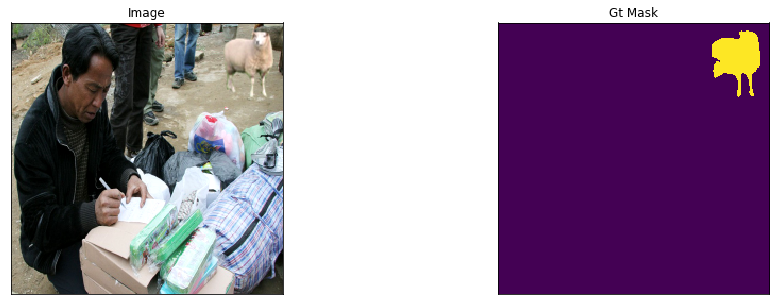

In [ ]:
sameple_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,)

sameple_image, sameple_mask = sameple_dataset[5] # get some sample
visualize(
        image=denormalize(sameple_image.squeeze()),
        gt_mask=sameple_mask[..., 0].squeeze(),
    )

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

D:\Installed\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [ ]:
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_casia.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
train_dataloader[0][1].shape

(10, 256, 256, 1)

In [ ]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
301/301 [==============================] - 124s 413ms/step - loss: 0.9073 - iou_score: 0.0642 - f1-score: 0.1127 - val_loss: 4.6816 - val_iou_score: 0.0609 - val_f1-score: 0.1015
Epoch 2/100
301/301 [==============================] - 103s 344ms/step - loss: 0.8863 - iou_score: 0.1007 - f1-score: 0.1724 - val_loss: 0.7746 - val_iou_score: 0.0244 - val_f1-score: 0.0389
Epoch 3/100
301/301 [==============================] - 105s 349ms/step - loss: 0.8795 - iou_score: 0.1169 - f1-score: 0.1971 - val_loss: 1.0294 - val_iou_score: 0.1308 - val_f1-score: 0.1855
Epoch 4/100
301/301 [==============================] - 106s 351ms/step - loss: 0.8648 - iou_score: 0.1362 - f1-score: 0.2269 - val_loss: 1.1015 - val_iou_score: 0.1423 - val_f1-score: 0.2105
Epoch 5/100
301/301 [==============================] - 105s 350ms/step - loss: 0.8494 - iou_score: 0.1521 - f1-score: 0.2510 - val_loss: 0.86

Epoch 41/100
301/301 [==============================] - 105s 348ms/step - loss: 0.4633 - iou_score: 0.4724 - f1-score: 0.6143 - val_loss: 0.1644 - val_iou_score: 0.4203 - val_f1-score: 0.4866
Epoch 42/100
301/301 [==============================] - 105s 348ms/step - loss: 0.4496 - iou_score: 0.4905 - f1-score: 0.6277 - val_loss: 0.2015 - val_iou_score: 0.4361 - val_f1-score: 0.5041
Epoch 43/100
301/301 [==============================] - 105s 349ms/step - loss: 0.4414 - iou_score: 0.5009 - f1-score: 0.6371 - val_loss: 0.1922 - val_iou_score: 0.4380 - val_f1-score: 0.5013
Epoch 44/100
301/301 [==============================] - 105s 349ms/step - loss: 0.4436 - iou_score: 0.4944 - f1-score: 0.6331 - val_loss: 0.1866 - val_iou_score: 0.4627 - val_f1-score: 0.5304
Epoch 45/100
301/301 [==============================] - 105s 349ms/step - loss: 0.4478 - iou_score: 0.4903 - f1-score: 0.6291 - val_loss: 0.1864 - val_iou_score: 0.3922 - val_f1-score: 0.4505
Epoch 46/100
301/301 [==================

Epoch 84/100
301/301 [==============================] - 105s 350ms/step - loss: 0.3351 - iou_score: 0.5946 - f1-score: 0.7212 - val_loss: 0.1604 - val_iou_score: 0.5116 - val_f1-score: 0.5736
Epoch 85/100
301/301 [==============================] - 104s 347ms/step - loss: 0.3313 - iou_score: 0.5975 - f1-score: 0.7258 - val_loss: 0.1590 - val_iou_score: 0.5093 - val_f1-score: 0.5707
Epoch 86/100
301/301 [==============================] - 105s 350ms/step - loss: 0.3362 - iou_score: 0.5934 - f1-score: 0.7199 - val_loss: 0.1597 - val_iou_score: 0.5117 - val_f1-score: 0.5738
Epoch 87/100
301/301 [==============================] - 105s 350ms/step - loss: 0.3379 - iou_score: 0.5930 - f1-score: 0.7186 - val_loss: 0.1604 - val_iou_score: 0.5099 - val_f1-score: 0.5716
Epoch 88/100
301/301 [==============================] - 105s 350ms/step - loss: 0.3393 - iou_score: 0.5889 - f1-score: 0.7166 - val_loss: 0.1605 - val_iou_score: 0.5085 - val_f1-score: 0.5702
Epoch 89/100
301/301 [==================

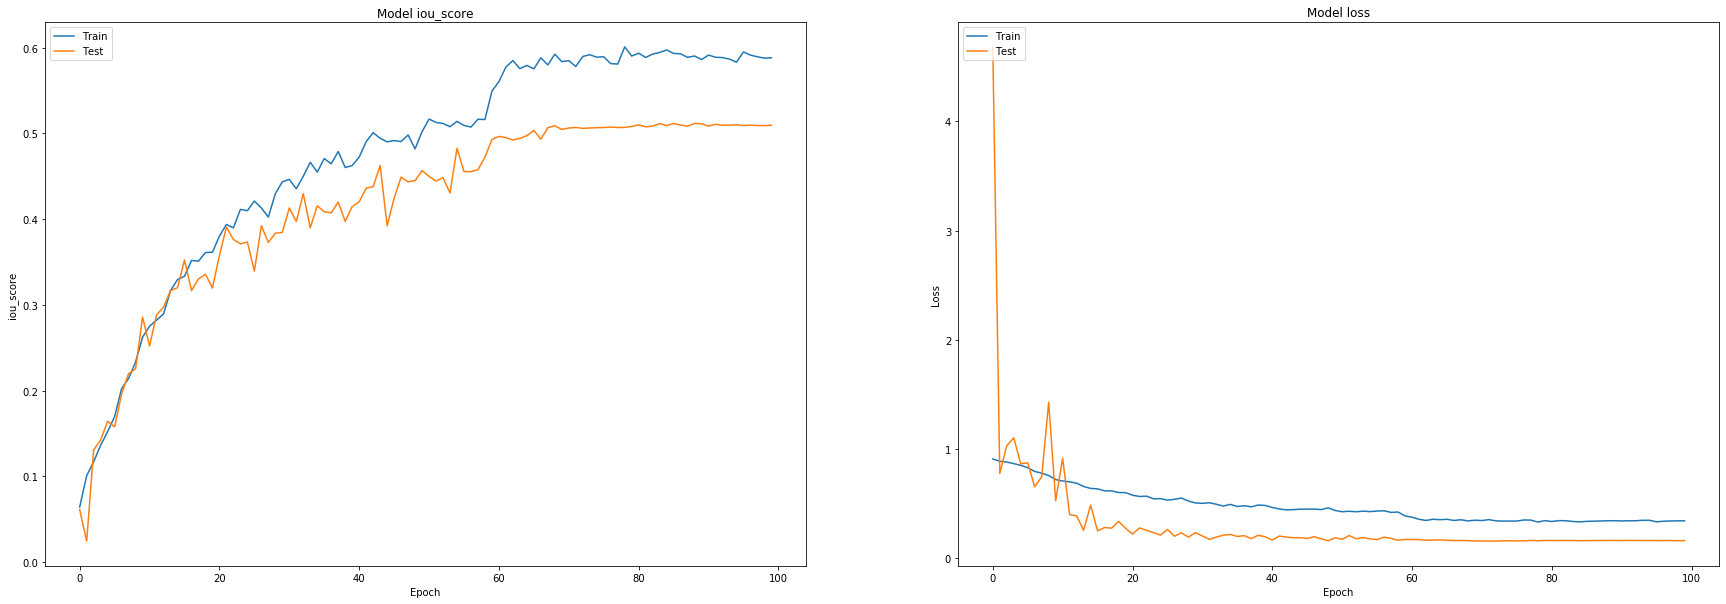

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation ##

In [ ]:
from 

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

D:\Installed\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [ ]:
model.load_weights('./best_model_casia.h5')

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.88765
mean iou_score: 0.47779
mean f1-score: 0.53739


## Visualization of results on test dataset ##

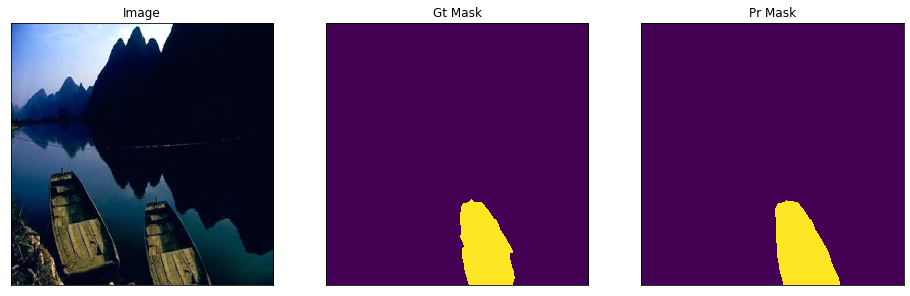

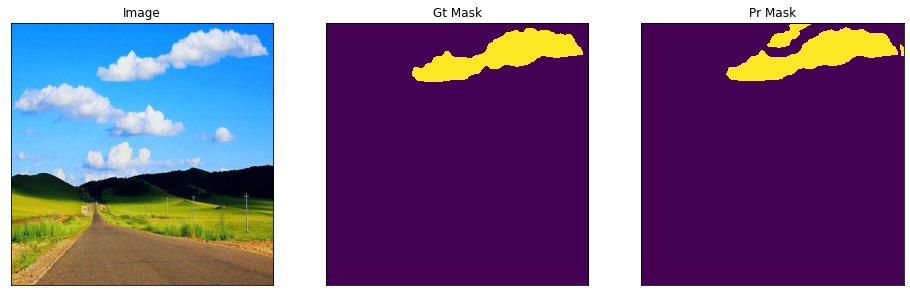

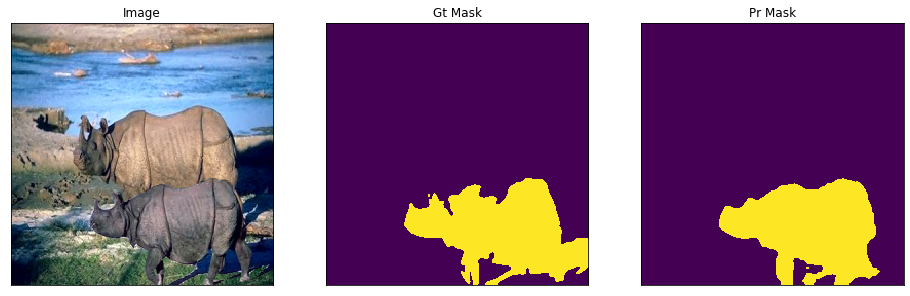

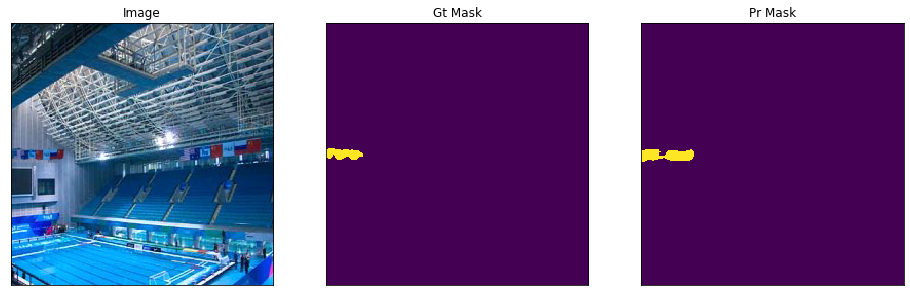

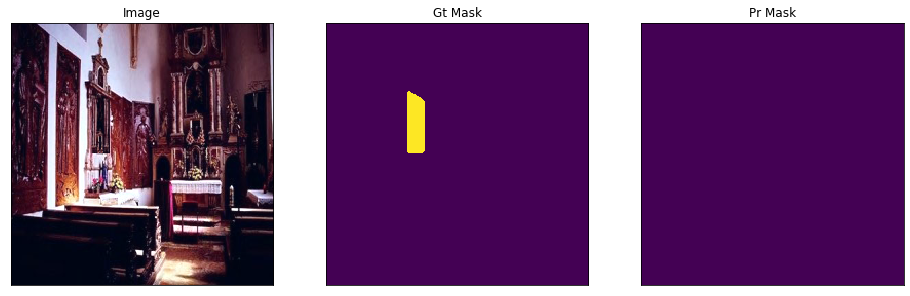

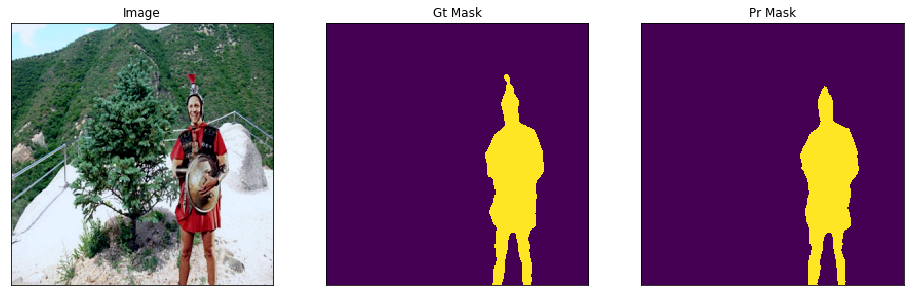

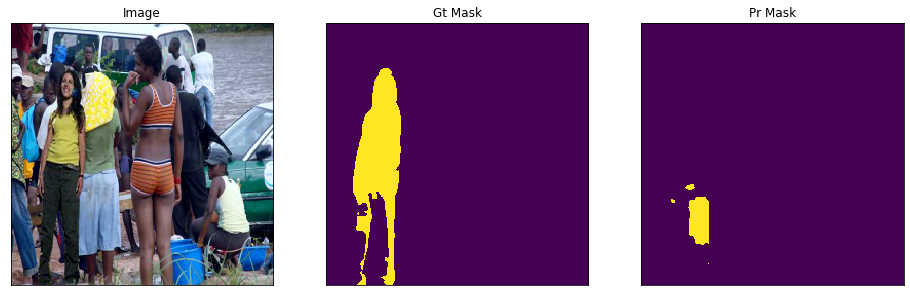

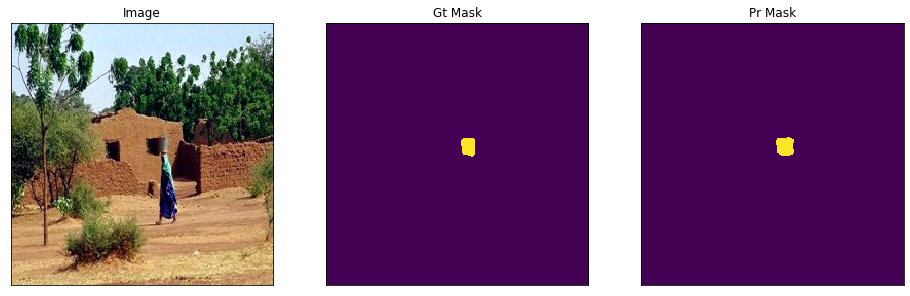

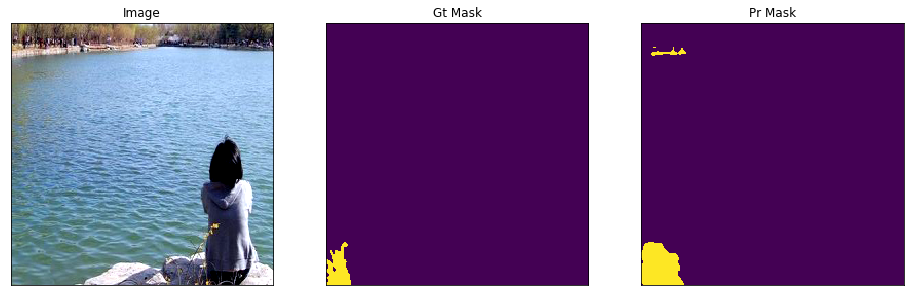

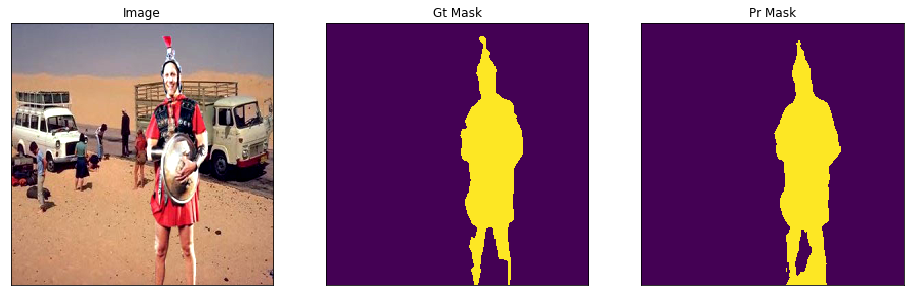

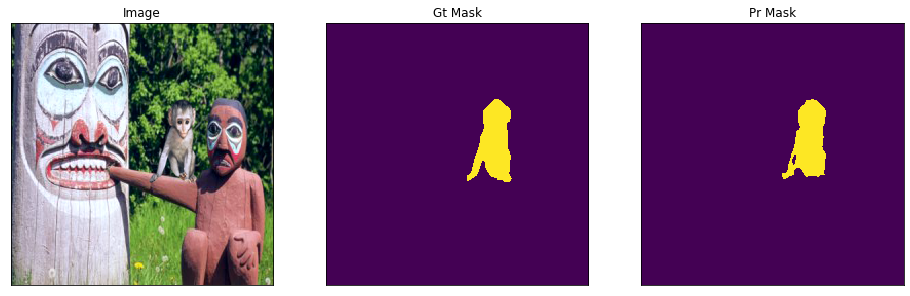

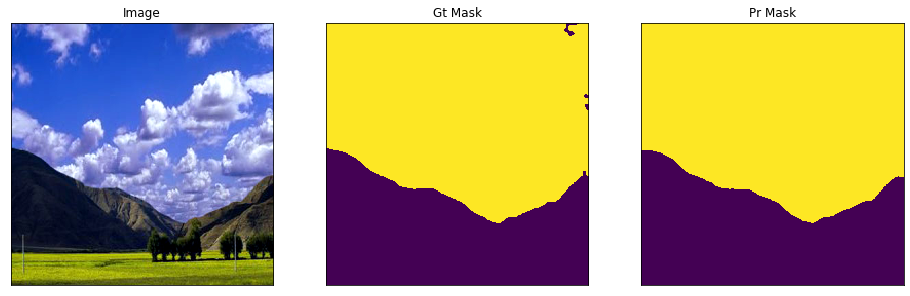

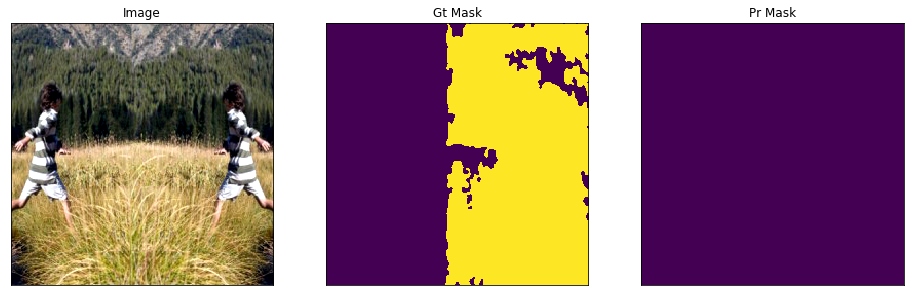

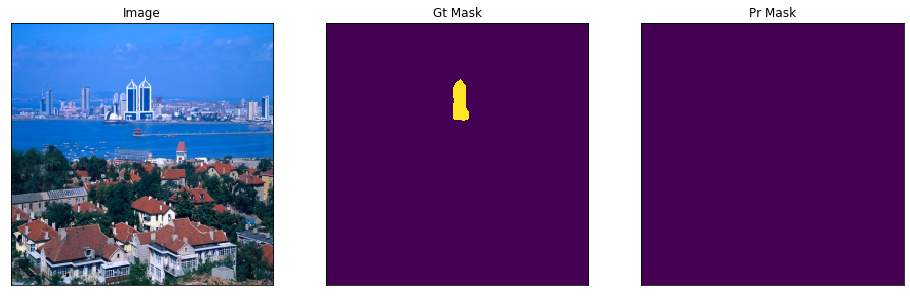

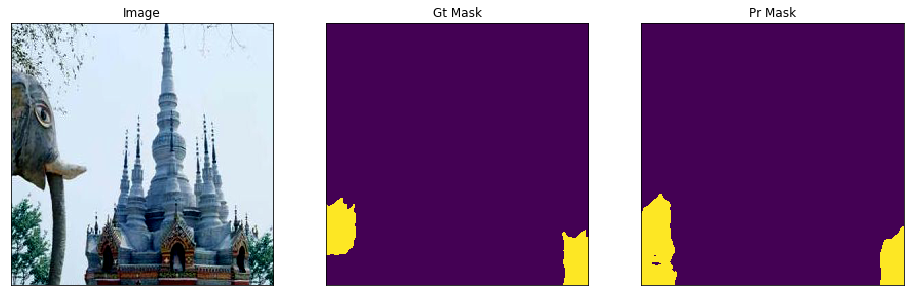

In [ ]:
n = 15
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )